In [25]:
! jupyter nbconvert --ClearMetadataPreprocessor.enabled=True --ClearOutput.enabled=True --to markdown README.ipynb

[NbConvertApp] Converting notebook README.ipynb to markdown
[NbConvertApp] Support files will be in README_files/
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Writing 9741 bytes to README.md


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import decomposition
import seaborn as sns

Read in copy number variant (CNV) and population information data

In [3]:
# read in cnv data
df = pd.read_csv('hm3_cnv_submission.txt', sep = '\t')

df.head()

,cnp_id,chr,start,end,NA06984,NA06985,NA06986,NA06989,NA06991,NA06993,...,NA21733,NA21738,NA21739,NA21740,NA21741,NA21768,NA21776,NA21784,NA21825,NA21826
0,HM3_CNP_1,1,8105049,8112441,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1,HM3_CNP_2,1,10292133,10300570,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2,HM3_CNP_3,1,10466423,10467633,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,HM3_CNP_4,1,12764515,12894420,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0
4,HM3_CNP_5,1,13647613,13649415,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0


In [4]:
# read in sample information into lists

YRI_file = open('YRI_samples.txt', 'r')
JPT_file = open('JPT_samples.txt', 'r')
CEU_file = open('CEU_samples.txt', 'r')
CHB_file = open('CHB_samples.txt', 'r')

YRI_data = YRI_file.read()
YRI = YRI_data.split('\n')

JPT_data = JPT_file.read()
JPT = JPT_data.split('\n')

CEU_data = CEU_file.read()
CEU = CEU_data.split('\n')

CHB_data = CHB_file.read()
CHB = CHB_data.split('\n')

YRI_file.close()
JPT_file.close()
CEU_file.close()
CHB_file.close()

In [5]:
# remove empty string at end of line
YRI.remove('')
JPT.remove('')
CEU.remove('')
CHB.remove('')

Prepare data for PCA

In [6]:
# set CNVs as index
df = df.set_index('cnp_id')

# remove unnecessary columns
df = df.iloc[:, 4:]

# impute NA
## will just fill the NA with 2.0, which is assuming uncalled CNVs have the normal 2 copies
df = df.fillna(2.0)


In [7]:
# transpose the matrix, because the population code for a given sample will be a column, so the samples will need to be the indexes
df = df.T

In [8]:
# write function to add correct population code for each sample
def assign_population(x):
    if x in CHB:
        return 'Chinese (CHB)'
    elif x in CEU:
        return 'European (CEU)'
    elif x in YRI:
        return 'African (YRI)'
    elif x in JPT:
        return 'Japanese (JPT)'
    else:
        return 'Unknown'

df['population_group'] = df.index.map(assign_population)

In [9]:
df.iloc[:,-1].head() #success!

NA06985    European (CEU)
NA06986           Unknown
NA06989           Unknown
NA06991    European (CEU)
NA06993    European (CEU)
Name: population_group, dtype: object

PCA

In [10]:
# create matrix for PCA
matrix = df.iloc[:, :-1]

# fit matrix
pca = decomposition.PCA(n_components = 2)
pca.fit(matrix)

PCA(n_components=2)

In [11]:
print(pca.singular_values_)

[108.03806355  75.84612477]


In [12]:
to_plot = pca.transform(matrix)
print(to_plot.shape)

(1183, 2)


Plot PCA

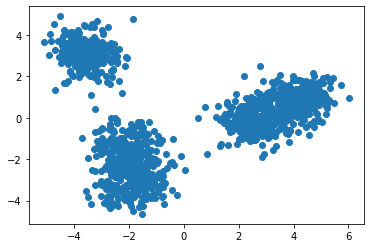

In [13]:
# make scatterplot
plt.scatter(x = to_plot[:,0], y = to_plot[:,1])

Above, we can see the CNV data clustered into 3 groups based on the first two principal components!

Will now add labeling to the data to see if clustering was indeed based on CNV differences between populations.

In [14]:
# create new data frame with population code, sample, PC1, and PC2
label_plot_df = pd.DataFrame({
    'Population_code' : df.population_group,
    'Sample' : df.index,
    'PC1' : to_plot[:,0],
    'PC2' : to_plot[:,1]
})

In [15]:
label_plot_df.head() # looks correct

,Population_code,Sample,PC1,PC2
NA06985,European (CEU),NA06985,-1.592362,-2.465608
NA06986,Unknown,NA06986,-2.406782,-2.861559
NA06989,Unknown,NA06989,-2.498762,-2.810846
NA06991,European (CEU),NA06991,-2.321385,-2.724843
NA06993,European (CEU),NA06993,-2.796366,-3.857086


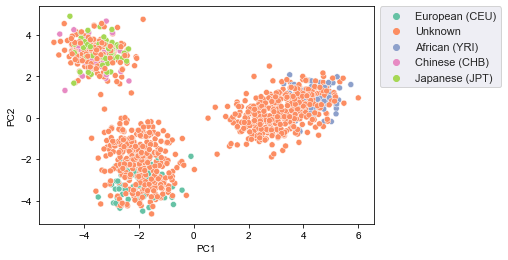

In [16]:
sns.scatterplot(
    x = 'PC1',
    y = 'PC2',
    data = label_plot_df,
    hue = 'Population_code',
    palette = sns.color_palette('Set2', 5)
)
sns.set(rc = {'figure.figsize':(15,8)})

plt.legend(bbox_to_anchor = (1.02, 1), loc = 'upper left', borderaxespad = 0)

Above, we can see that individuals of European ancestry are in the right cluster, individuals with Chinese and Japanese are in the left cluster, and individuals with African ancestry clustered in the middle. 

The observation aligns with the knowledge that genetic changes within a population occurred when humans began to migrate out of Africa and experienced environmental (and other) selective factors. It would make sense that the European and Asian clusters are further away from each other than from the African cluster.

There are many unlabeled individuals in the plot, let's remove them and look at the clusters without them.

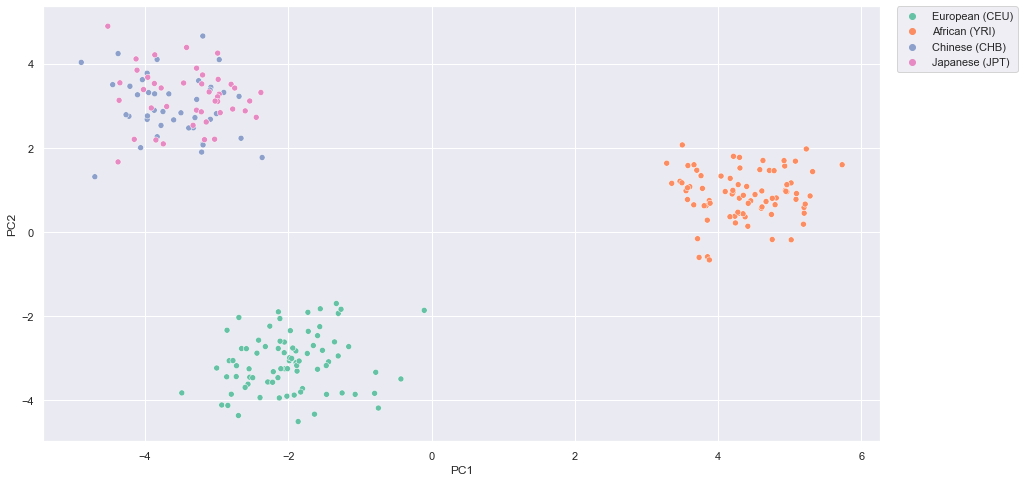

In [17]:
sns.scatterplot(
    x = 'PC1',
    y = 'PC2',
    data = label_plot_df.loc[label_plot_df.Population_code != 'Unknown'],
    hue = 'Population_code',
    palette = sns.color_palette('Set2', 4)
)
sns.set(rc = {'figure.figsize':(15,8)})

plt.legend(bbox_to_anchor = (1.02, 1), loc = 'upper left', borderaxespad = 0)

Trying tSNE

In [18]:
from sklearn.manifold import TSNE

In [19]:
X_embedded = TSNE(n_components = 2, learning_rate = 100 , init = "random").fit_transform(matrix)

X_embedded.shape

(1183, 2)

In [20]:
label_plot_df['tsne1'] = X_embedded[:, 0]
label_plot_df['tsne2'] = X_embedded[:, 1]


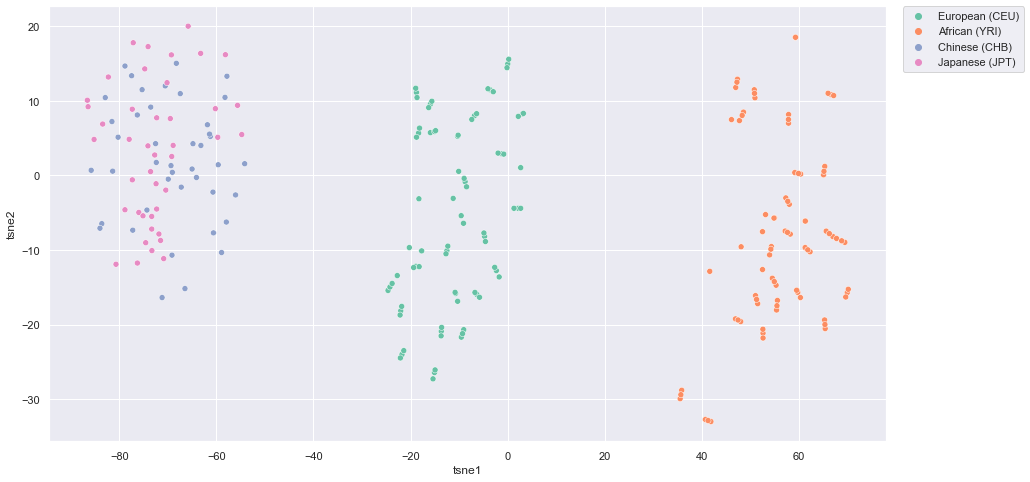

In [21]:
sns.scatterplot(
    x = 'tsne1',
    y = 'tsne2',
    data = label_plot_df.loc[label_plot_df.Population_code != 'Unknown'],
    hue = 'Population_code',
    palette = sns.color_palette('Set2', 4)
)
sns.set(rc = {'figure.figsize':(15,8)})

plt.legend(bbox_to_anchor = (1.02, 1), loc = 'upper left', borderaxespad = 0)